In [1]:
import os
import sys
sys.path.append("../")

import warnings
warnings.filterwarnings('ignore')

import torch
import torch.nn as nn

import numpy as np
import pandas as pd
import seaborn as sns
import plotly.express as px
import matplotlib as mpl
import matplotlib.pyplot as plt
plt.rcParams.update({'figure.max_open_warning': 0})

from sklearn.neighbors import NearestNeighbors
from sklearn.decomposition import PCA
from sklearn.manifold import MDS, TSNE, LocallyLinearEmbedding
from sklearn.preprocessing import normalize

from tsnecuda import TSNE
from IPython.display import display
from PIL import Image

from datasets.wafer import WM811K
from datasets.wafer import get_dataloader
from datasets.transforms import WM811KTransform
from datasets.samplers import ImbalancedDatasetSampler
from models.config import ALEXNET_BACKBONE_CONFIGS, VGGNET_BACKBONE_CONFIGS, RESNET_BACKBONE_CONFIGS
from models.alexnet import AlexNetBackbone
from models.vggnet import VggNetBackbone
from models.resnet import ResNetBackbone
from models.head import NonlinearProjector
from tasks.pirl import PIRL, MemoryBank

# 1. Load data

In [2]:
transform = WM811KTransform(size=(96, 96), mode='wapirl-v1')

In [3]:
data_dir = '../data/wm811k/labeled/'
train_set = WM811K(data_dir + 'train', transform=transform)
valid_set = WM811K(data_dir + 'valid', transform=transform)
test_set  = WM811K(data_dir + 'test', transform=transform)
print(f"Train : Validation : Test = {len(train_set):,} : {len(valid_set):,} : {len(test_set):,}")

Train : Validation : Test = 138,360 : 17,295 : 17,295


# 2. Instantiate PIRL backbones (ResNet-18)

In [4]:
cfg = dict(
    backbone_type='resnet',
    backbone_config='18.original',
    in_channels=2,
    projector_type='mlp',
    projector_size=128,
    num_negatives=5000,
    augmentation='wapirl-v2'
)

In [5]:
backbone = ResNetBackbone(RESNET_BACKBONE_CONFIGS[cfg['backbone_config']], in_channels=cfg['in_channels'])
print(f"#. parameters of {backbone.__class__.__name__}: {sum(p.numel() for p in backbone.parameters()):,}")

#. parameters of ResNetBackbone: 11,173,376


In [6]:
projector = NonlinearProjector(in_channels=backbone.out_channels, num_features=cfg['projector_size'])
print(f"#. parameters of {projector.__class__.__name__}: {sum(p.numel() for p in projector.parameters()):,}")

#. parameters of NonlinearProjector: 328,320


# 3. T-SNE (Using `tsnecuda`)

## 3-1. Define functions

In [36]:
def predict_embeddings(dataset: torch.utils.data.Dataset, backbone: nn.Module, head: nn.Module, device: str, **kwargs):
    
    balance = True
    
    data_loader = get_dataloader(
        dataset,
        batch_size=kwargs.get('batch_size', 2048), 
        shuffle=False,
        pin_memory=False,
        balance=balance,
        num_workers=kwargs.get('num_workers', 0)
    )
    
    backbone = backbone.to(device)
    head     = head.to(device)
    
    backbone.eval()
    head.eval()
    
    embeddings = []
    targets    = []
    
    with torch.no_grad():
        for _, batch in enumerate(data_loader):
            
            idx = batch['idx'].to(device)
            x = batch['x'].to(device)
            
            emb = head(backbone(x))
            embeddings += [emb.cpu()]
            targets += [batch['y'].cpu()]
            
            if kwargs.get('log', False):
                print('.', end='')
    
    backbone = backbone.to('cpu')
    head     = head.to('cpu')
    torch.cuda.empty_cache()
    
    embeddings = torch.cat(embeddings, dim=0)
    targets = torch.cat(targets, dim=0)
    
    return embeddings, targets

In [58]:
def fit_tsne(*X, ppl: int=15, lr: float=10, device=0, pca: bool=False, **kwargs):
    
    split_indices = [0]
    for x in X:
        split_indices += [split_indices[-1] + len(x)]
    split_indices = split_indices[1:]
    
    X_ = [torch.nn.functional.normalize(x, dim=1) for x in X]  # l2-normalize
    X_ = [x.numpy() for x in X]                                # torch.Tensor -> np.ndarray 
    X_ = np.concatenate(X_, axis=0)                            # (B, F)
    
    if pca:
        from sklearn.decomposition import PCA
        pca = PCA(kwargs.get('pca_components', 10)) 
        X_ = pca.fit_transform(X_)
        for i, v in enumerate(pca.explained_variance_ratio_):
            print(f"PC{i+1}: {v*100:.2f}%", end=' | ')
        
        
    
    tsne = TSNE(n_components=2, num_neighbors=64, n_iter=20000, perplexity=ppl, learning_rate=lr, device=device)
    Z = tsne.fit_transform(X_)
    
    return np.split(Z, split_indices)[:-1]  # last item is empty
    

## 3-2. Find checkpoints

In [59]:
ckpt_dir = f"../checkpoints/wm811k/pirl/{cfg['backbone_type']}.{cfg['backbone_config']}/{cfg['augmentation']}/"
if os.path.isdir(ckpt_dir):
    print(*sorted(os.listdir(ckpt_dir)), sep='\n')

best_history.json
best_memory.pt
best_model.pt
configs.json
epoch_0010.loss_0.4045.pt
epoch_0020.loss_0.4597.pt
epoch_0030.loss_0.6453.pt
epoch_0040.loss_0.6555.pt
epoch_0050.loss_0.6300.pt
epoch_0060.loss_0.5885.pt
epoch_0070.loss_0.6908.pt
epoch_0080.loss_0.7072.pt
epoch_0090.loss_0.6230.pt
epoch_0100.loss_0.6015.pt
epoch_0110.loss_0.6335.pt
epoch_0120.loss_0.7210.pt
epoch_0130.loss_0.7250.pt
epoch_0140.loss_0.7910.pt
epoch_0150.loss_0.8628.pt
events.out.tfevents.1595945032.8f3e9cdf7fb9.30715.0
last_history.json
last_memory.pt
last_model.pt
loss_train
loss_valid
main.log
top@1_train
top@1_valid
top@5_train
top@5_valid


In [60]:
def find_ckpts(ckpt_dir: str, epochs: list):
    ckpts = [c for c in os.listdir(ckpt_dir) if c.startswith('epoch')]
    ckpts = [c for c in ckpts if int(c.split('_')[1].split('.')[0]) in epochs]
    ckpts = [os.path.join(ckpt_dir, c) for c in ckpts]
    return sorted(ckpts)

In [61]:
ckpts = find_ckpts(ckpt_dir, epochs=[10, 50, 100, 150])
print(*ckpts, sep='\n')

../checkpoints/wm811k/pirl/resnet.18.original/wapirl-v2/epoch_0010.loss_0.4045.pt
../checkpoints/wm811k/pirl/resnet.18.original/wapirl-v2/epoch_0050.loss_0.6300.pt
../checkpoints/wm811k/pirl/resnet.18.original/wapirl-v2/epoch_0100.loss_0.6015.pt
../checkpoints/wm811k/pirl/resnet.18.original/wapirl-v2/epoch_0150.loss_0.8628.pt


In [62]:
DEVICE = 0

In [63]:
labels = train_set.idx2label[:-1]
label2color = {
    'center': 'tab:blue',
    'donut': 'tab:orange',
    'edge-loc': 'tab:green',
    'edge-ring': 'tab:red',
    'loc': 'tab:purple',
    'random': 'tab:brown',
    'scratch': 'tab:pink',
    'near-full': 'tab:cyan',
    'none': 'tab:gray'
}

target2color = [v for _, v in label2color.items()]

Loaded trained weights from: ../checkpoints/wm811k/pirl/resnet.18.original/wapirl-v2/epoch_0010.loss_0.4045.pt
Fit t-SNE...


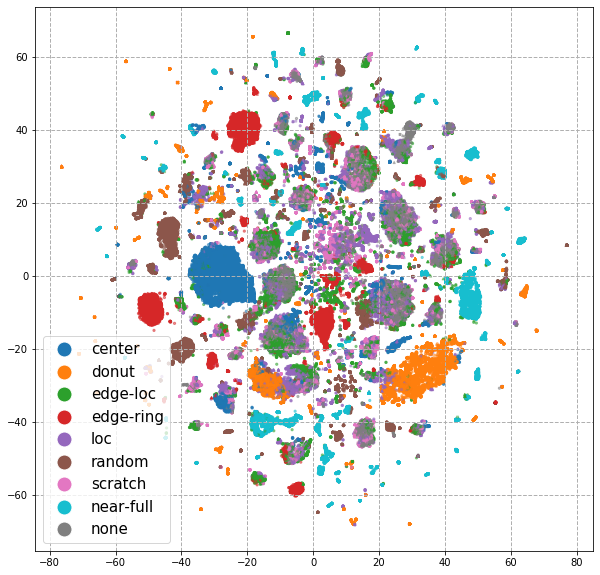

Loaded trained weights from: ../checkpoints/wm811k/pirl/resnet.18.original/wapirl-v2/epoch_0050.loss_0.6300.pt
Fit t-SNE...


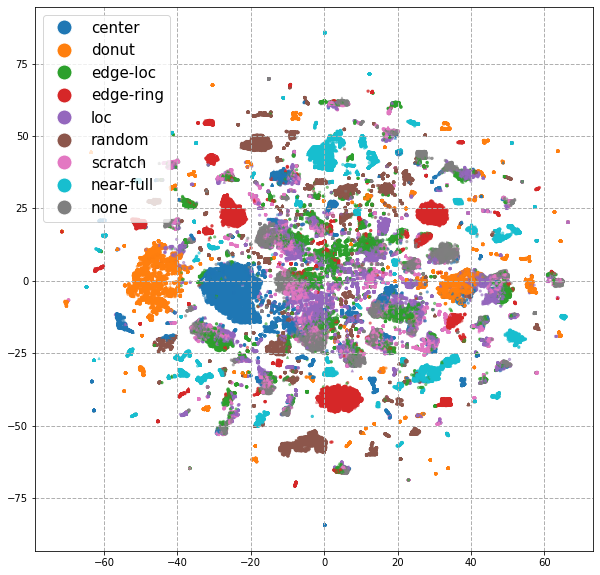

Loaded trained weights from: ../checkpoints/wm811k/pirl/resnet.18.original/wapirl-v2/epoch_0100.loss_0.6015.pt
Fit t-SNE...


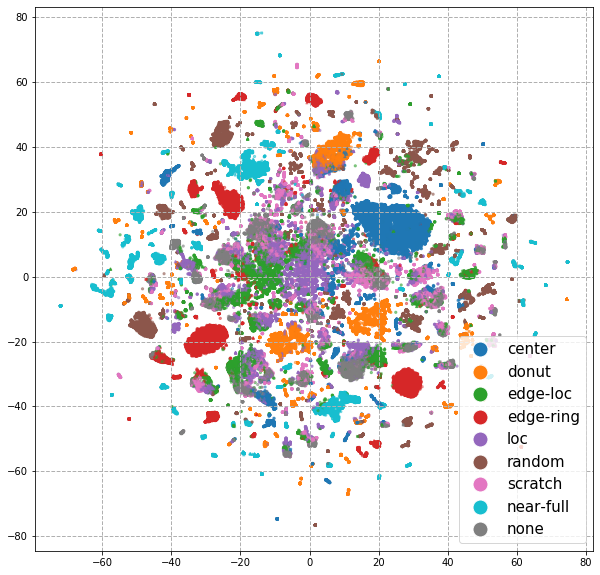

Loaded trained weights from: ../checkpoints/wm811k/pirl/resnet.18.original/wapirl-v2/epoch_0150.loss_0.8628.pt
Fit t-SNE...


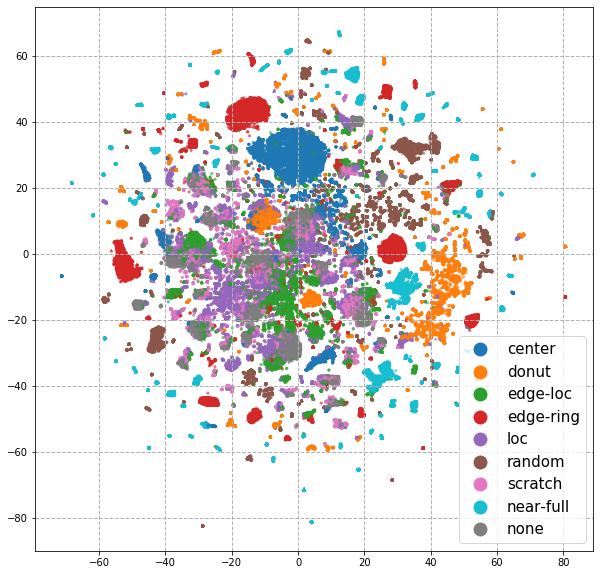

CPU times: user 6min 49s, sys: 2min 4s, total: 8min 54s
Wall time: 10min 33s


In [65]:
%%time

for ckpt in ckpts:
    
    # Load weights
    backbone.load_weights_from_checkpoint(ckpt, key='backbone')
    projector.load_weights_from_checkpoint(ckpt, key='projector')
    print('Loaded trained weights from:', ckpt)
    # print('Model is currently loaded on:', next(backbone.parameters()).device)
    
    # Inference
    train_embeddings, train_targets = predict_embeddings(train_set, backbone=backbone, head=projector, device=DEVICE, log=False, num_workers=4)
    valid_embeddings, valid_targets = predict_embeddings(valid_set, backbone=backbone, head=projector, device=DEVICE, log=False, num_workers=4)
    test_embeddings, test_targets = predict_embeddings(test_set, backbone=backbone, head=projector, device=DEVICE, log=False, num_workers=4)
    
    # Fit t-sne
    print('Fit t-SNE...')
    Z_train, Z_valid, Z_test = fit_tsne(train_embeddings, valid_embeddings, test_embeddings ,ppl=50., pca=False, pca_components=50, lr=20.)
    
    # Plot t-sne
    fig, ax = plt.subplots(1, 1, figsize=(10, 10))
    ax.scatter(Z_train[:, 0], Z_train[:, 1],
               color=[target2color[t] for t in train_targets],
               s=5., alpha=.5, marker='o')
    ax.scatter(Z_valid[:, 0], Z_valid[:, 1],
               color=[target2color[t] for t in valid_targets],
               s=5., alpha=.5, marker='x')
    ax.scatter(Z_test[:, 0], Z_test[:, 1],
               color=[target2color[t] for t in test_targets],
               s=5., alpha=.5, marker='^')
    ax.grid(True, which='major', axis='both', linewidth=1., linestyle='--')
    
    from matplotlib.lines import Line2D
    legend_elements = [
        Line2D([0], [0], marker='o', color='w', label=l, markerfacecolor=c, markersize=15) for l, c in label2color.items()
    ]
    
    ax.legend(handles=legend_elements, loc='best', fontsize=15)
    plt.show(fig)


In [ ]:
# Convert to numpy arrays
train_penultimates, train_embeddings, train_targets = train_penultimates.numpy(), train_embeddings.numpy(), train_targets.numpy()
test_penultimates, test_embeddings, test_targets   = test_penultimates.numpy(), test_embeddings.numpy(), test_targets.numpy()

In [ ]:
# Normalize such that |v| = 1 (i.e. independently normalize each sample)
l2norm_configs = dict(norm='l2', axis=1, return_norm=False)

train_penultimates = normalize(train_penultimates, **l2norm_configs)
test_penultimates = normalize(test_penultimates, **l2norm_configs)

train_embeddings = normalize(train_embeddings, **l2norm_configs)
test_embeddings  = normalize(test_embeddings, **l2norm_configs)

# Nearest Neighbors

In [ ]:
nn_configs = dict(metric='euclidean', n_neighbors=5, n_jobs=16)
neigh = NearestNeighbors(**nn_configs)

In [ ]:
%%time
neigh.fit(train_penultimates)

In [ ]:
%%time
neigh_dist, neigh_ind = neigh.kneighbors(X=test_penultimates, return_distance=True)

In [ ]:
neigh_dist

In [ ]:
neigh_ind

In [ ]:
LABEL_OF_INTEREST = 'none'
MAX_COUNT = 100

In [ ]:
label_count = {l: 0 for l, _ in WM811K_LABELS.items()}

COUNT = 0
SIZE = (112, 112)
for i, (image_path, target) in enumerate(test_set.samples):
    
    label = target2label[target]
    if label != LABEL_OF_INTEREST:
        continue
    
    fig, axes = plt.subplots(1, 6, figsize=(20, 5))
    
    # Query image (from test set)
    query_image = Image.open(image_path)
    axes[0].imshow(query_image.resize(SIZE, resample=Image.NEAREST), cmap=plt.cm.binary)
    axes[0].tick_params(axis='both', which='both', 
                        left=False, bottom=False, top=False, 
                        labelleft=False, labelbottom=False)
    #axes[0].set_title(f'Query ({i:,}, Label: {label})')
    
    # Nearest neighbor images (k=5)
    for ax, n_ind in zip(axes[1:], neigh_ind[i]):
        image_path, target = train_set.samples[n_ind]
        ax.imshow(Image.open(image_path).resize(SIZE, resample=Image.NEAREST), cmap=plt.cm.binary)
        #ax.set_title(f'{n_ind:,}, Label: {target2label[target]}')
        ax.axis('off')
        
    if COUNT > MAX_COUNT:
        break
    
    COUNT += 1

# Visualization

In [ ]:
%%time

# T-SNE
tsne = TSNE(n_components=2, perplexity=50, verbose=1)
Z_tsne = pd.DataFrame(tsne.fit_transform(test_embeddings))
Z_tsne.columns = ['D1', 'D2']
Z_tsne['label'] = [target2label[t] for t in test_targets]

In [ ]:
fig = px.scatter(Z_tsne, x='D1', y='D2', color='label')
fig.show()

In [ ]:
%%time

# Multidimensional Scaling (MDS)
mds = MDS(n_components=2, metric=True, dissimilarity='euclidean', n_jobs=8)
Z = pd.DataFrame(mds.fit_transform(test_embeddings))
Z.columns = ['D1', 'D2']

In [ ]:
from datasets.wafer import WM811K_LABELS

In [ ]:
Z.shape

In [ ]:
pca = PCA(n_components=3)
Z = pd.DataFrame(pca.fit_transform(test_embeddings))
Z.columns = [f"PC{i+1}" for i in range(pca.n_components_)]

In [ ]:
Z['targets'] = test_targets

In [ ]:
scatter_kwargs = dict(x='PC1', y='PC2', z='PC3', color='targets')
fig = px.scatter_3d(Z, **scatter_kwargs)
fig.show()

In [ ]:
def plot_PCA(X: np.ndarray, targets: np.ndarray, **kwargs):
    """Plot 2D scatter plot with PCA."""
    
    pca = PCA()
    Z = pca.fit_transform(X)
    
    fig, ax = plt.subplots(1, 1, figsize=kwargs.get('figsize', (10, 10)))
    ax.scatter(Z[:, 0], Z[:, 1], c=targets, alpha=0.25, cmap=kwargs.get('cmap', plt.cm.Set2))
    plt.show(fig)
    

In [ ]:
plot_PCA(test_embeddings, test_targets)

In [ ]:
list(range(1, 3))